# Data Preprocessing for Electric Load Forecasting

This notebook demonstrates a production-style data preprocessing pipeline for electric load forecasting. We combine electricity demand and weather data for ten major U.S. cities, ensuring robust merging, cleaning, feature engineering, aggregation, and anomaly detection.

## Import Required Libraries

In [79]:
%pip install pandas numpy matplotlib seaborn scikit-learn

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [80]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.ensemble import IsolationForest
from datetime import datetime
import os
import json
from glob import glob
import re
from scipy.stats import zscore
from sklearn.ensemble import IsolationForest

# Set display options
pd.set_option('display.max_columns', None)
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_context("notebook", font_scale=1.2)

## 1. Loading & Inspection

We load and merge all CSV files for the ten cities into a single unified dataset. City names are standardized (canonicalized) and timestamps are converted to datetime objects. This ensures that, for example, 'New York', 'NEW YORK', and 'new york' are all treated as 'new_york'. We then review the schema and sample records.

In [81]:
dataset_path = "/Users/aaqibnazir/Documents/uni/semester_6/data_mining_project/dataset"

def canonical(city: str) -> str:
    return re.sub(r"\s+", "_", city.strip().lower())

In [82]:
demand_frames = []
for f in ["cleaned_balance_data.csv", "cleaned_subregion_data.csv"]:
    file_path = os.path.join(dataset_path, f)
    if os.path.exists(file_path):
        dataset = pd.read_csv(file_path)
        if not dataset.empty:
            time_col = "local_time" if "local_time" in dataset.columns else "utc_time"
            if time_col in dataset.columns and "city" in dataset.columns and "demand" in dataset.columns:
                dataset["timestamp"] = pd.to_datetime(dataset[time_col])
                dataset["city"] = dataset["city"].map(canonical)
                demand_frames.append(dataset[["timestamp", "city", "demand"]])
            else:
                print(f"File {f} is missing required columns.")
        else:
            print(f"File {f} is empty.")
    else:
        print(f"File {f} not found.")

tx_path = os.path.join(dataset_path, "cleaned_texas_data.csv")
if os.path.exists(tx_path):
    tx = pd.read_csv(tx_path)
    if not tx.empty:
        if "date" in tx.columns:
            tx = (tx.rename(columns={"date": "timestamp"})
                  .melt(id_vars="timestamp", var_name="city", value_name="demand"))
            tx["timestamp"] = pd.to_datetime(tx["timestamp"])
            tx["city"] = tx["city"].map(canonical)
            demand_frames.append(tx)
        else:
            print("Texas data file is missing the 'date' column.")
    else:
        print("Texas data file is empty.")
else:
    print("Texas data file not found.")

if demand_frames:
    demand = pd.concat(demand_frames, ignore_index=True).dropna(subset=["demand"]).sort_values(["city", "timestamp"])
    print("Demand data shape:", demand.shape)
    print(demand.head())
else:
    print("No valid data to concatenate.")

Demand data shape: (199429, 3)
                 timestamp    city    demand
205077 2018-01-01 00:00:00  dallas  18346.96
205054 2018-01-01 01:00:00  dallas  18584.34
205055 2018-01-01 02:00:00  dallas  18524.14
205056 2018-01-01 03:00:00  dallas  18532.06
205057 2018-01-01 04:00:00  dallas  18647.44


## 2. Merging Weather Data

We load weather data from JSON files for each city, standardize city names, and convert timestamps. We then merge the demand and weather data on both 'city' and 'timestamp' using an inner join. This ensures city-specific matching, prevents cross-location data mixing, and avoids data multiplication.

### Key Merging Details
- **Merge Keys**: Data is merged on `["city", "timestamp"]` using an inner join
- **Canonical City Names**: City names are standardized to lowercase with underscores
- **Proper Timestamp Handling**: All timestamp fields are converted to datetime objects
- **Inner Join**: Only records where both the city and timestamp match will be kept

In [83]:
def load_weather(path):
    arr = json.load(open(path))
    df = pd.DataFrame(arr)
    for col in ['time', 'timestamp', 'date']:
        if col in df.columns:
            df['timestamp'] = pd.to_datetime(df[col], unit='s' if col == 'time' else None)
            break
    df['city'] = canonical(os.path.splitext(os.path.basename(path))[0])
    keep = ["timestamp", "city", "temperature", "humidity", "windSpeed", "pressure", "precipIntensity", "precipProbability"]
    return df[[c for c in keep if c in df.columns]]

weather_files = glob(os.path.join(dataset_path, "*.json"))
weather = pd.concat([load_weather(p) for p in weather_files], ignore_index=True)

merged_data = pd.merge(demand, weather, on=["city", "timestamp"], how="inner")
print("Merged data shape:", merged_data.shape)
print(merged_data.head())

Merged data shape: (186142, 9)
            timestamp    city    demand  temperature  humidity  windSpeed  \
0 2018-07-02 05:00:00  dallas  13839.70        89.56      0.45      10.84   
1 2018-07-02 06:00:00  dallas  14067.03        88.35      0.52       9.94   
2 2018-07-02 07:00:00  dallas  14323.09        87.05      0.56       8.92   
3 2018-07-02 08:00:00  dallas  14652.59        86.04      0.58       8.47   
4 2018-07-02 09:00:00  dallas  15582.09        84.80      0.63       5.61   

   pressure  precipIntensity  precipProbability  
0    1011.9              0.0                0.0  
1    1012.7              0.0                0.0  
2    1012.8              0.0                0.0  
3    1012.7              0.0                0.0  
4    1012.9              0.0                0.0  


### Weather Data Distribution

Let's visualize the distribution of weather variables across cities to understand their characteristics and detect potential issues.

/var/folders/ts/5lrll2nx1511bvwlbt5yh_940000gn/T/ipykernel_524/3941861511.py:8: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0, 0].set_xticklabels(axes[0, 0].get_xticklabels(), rotation=45)
/var/folders/ts/5lrll2nx1511bvwlbt5yh_940000gn/T/ipykernel_524/3941861511.py:14: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0, 1].set_xticklabels(axes[0, 1].get_xticklabels(), rotation=45)
/var/folders/ts/5lrll2nx1511bvwlbt5yh_940000gn/T/ipykernel_524/3941861511.py:20: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1, 0].set_xticklabels(axes[1, 0].get_xticklabels(), rotation=45)
/var/folders/ts/5lrll2nx1511bvwlbt5yh_940000gn/T/ipykernel_524/3941861511.py:26: UserWarning: set_ticklabels() should only be used with a fixed number of tick

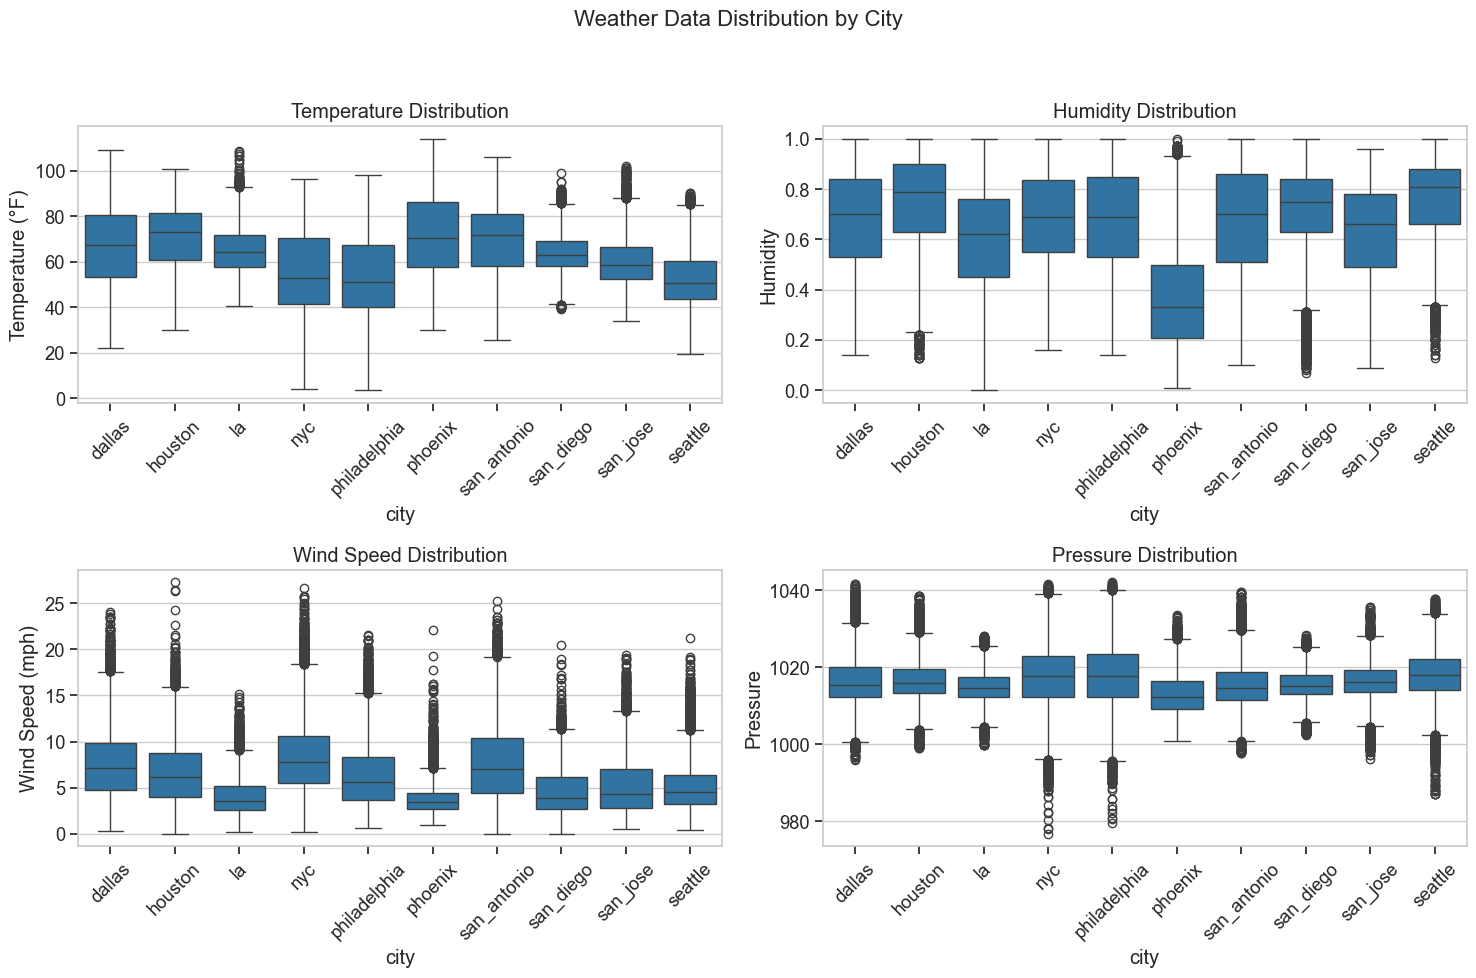

In [84]:
# Set up the figure with a grid of subplots
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('Weather Data Distribution by City', fontsize=16)

# Temperature distribution by city
sns.boxplot(x='city', y='temperature', data=merged_data, ax=axes[0, 0])
axes[0, 0].set_title('Temperature Distribution')
axes[0, 0].set_xticklabels(axes[0, 0].get_xticklabels(), rotation=45)
axes[0, 0].set_ylabel('Temperature (°F)')

# Humidity distribution by city
sns.boxplot(x='city', y='humidity', data=merged_data, ax=axes[0, 1])
axes[0, 1].set_title('Humidity Distribution')
axes[0, 1].set_xticklabels(axes[0, 1].get_xticklabels(), rotation=45)
axes[0, 1].set_ylabel('Humidity')

# Wind speed distribution by city
sns.boxplot(x='city', y='windSpeed', data=merged_data, ax=axes[1, 0])
axes[1, 0].set_title('Wind Speed Distribution')
axes[1, 0].set_xticklabels(axes[1, 0].get_xticklabels(), rotation=45)
axes[1, 0].set_ylabel('Wind Speed (mph)')

# Pressure distribution by city
sns.boxplot(x='city', y='pressure', data=merged_data, ax=axes[1, 1])
axes[1, 1].set_title('Pressure Distribution')
axes[1, 1].set_xticklabels(axes[1, 1].get_xticklabels(), rotation=45)
axes[1, 1].set_ylabel('Pressure')

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

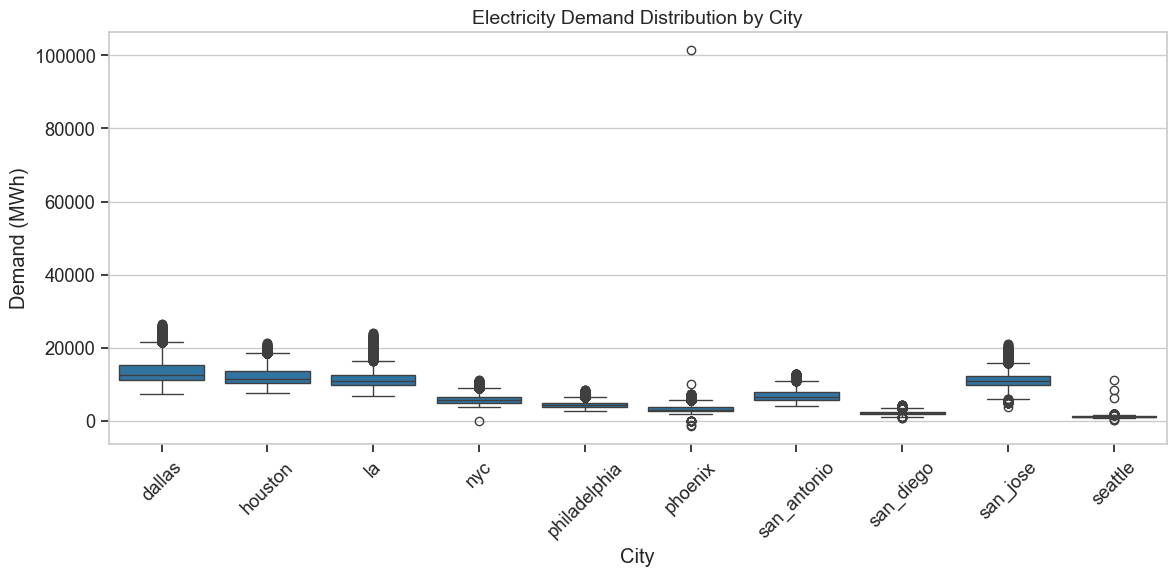

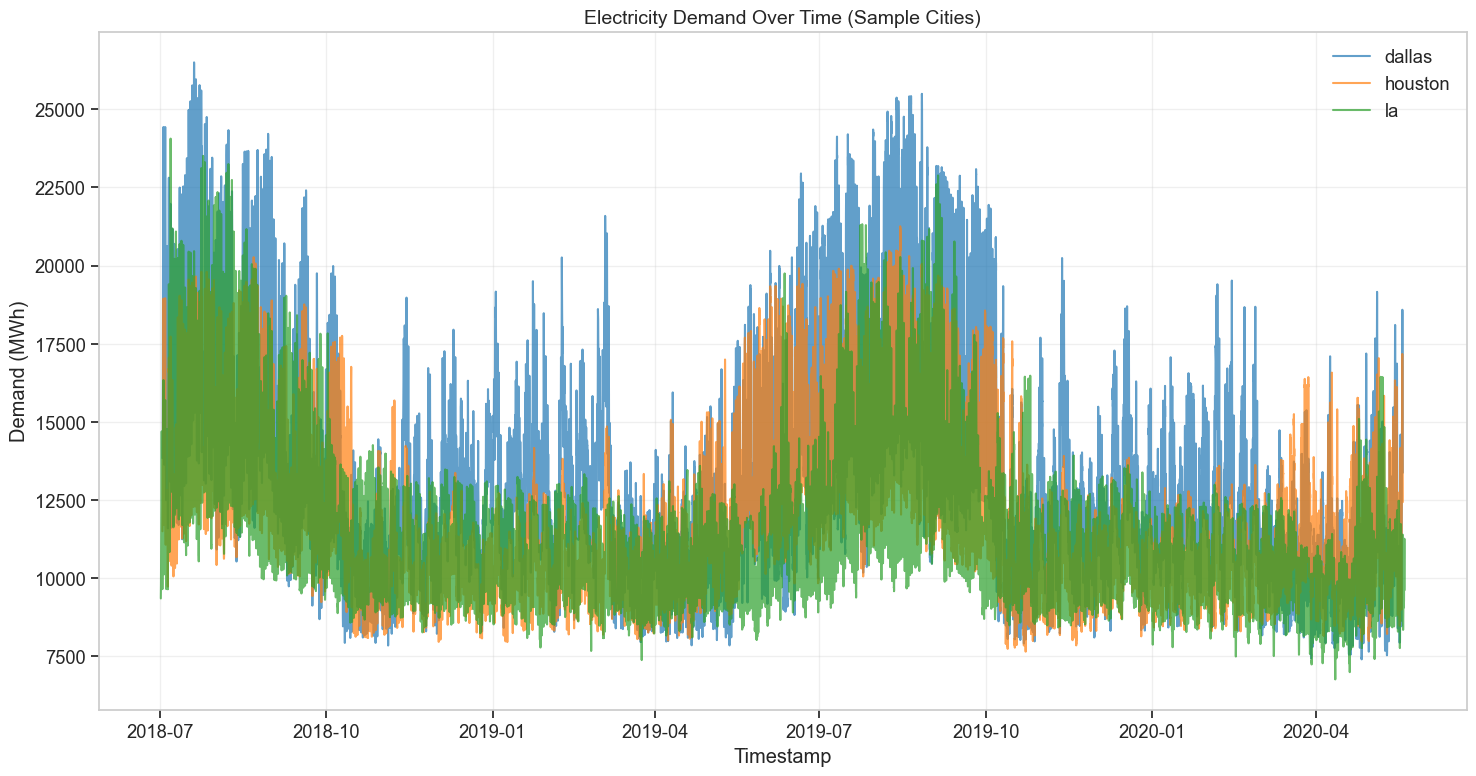

In [85]:
plt.figure(figsize=(12, 6))
sns.boxplot(x='city', y='demand', data=merged_data)
plt.title('Electricity Demand Distribution by City', fontsize=14)
plt.xticks(rotation=45)
plt.ylabel('Demand (MWh)')
plt.xlabel('City')
plt.tight_layout()
plt.show()

plt.figure(figsize=(15, 8))
for city in merged_data['city'].unique()[:3]: 
    city_data = merged_data[merged_data['city'] == city].sort_values('timestamp')
    plt.plot(city_data['timestamp'], city_data['demand'], label=city, alpha=0.7)

plt.title('Electricity Demand Over Time (Sample Cities)', fontsize=14)
plt.xlabel('Timestamp')
plt.ylabel('Demand (MWh)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## 3. Missing Values

We identify missing values and impute them using the median for each city, preserving local patterns. This city-specific approach ensures that the imputed values respect the unique characteristics of each location.

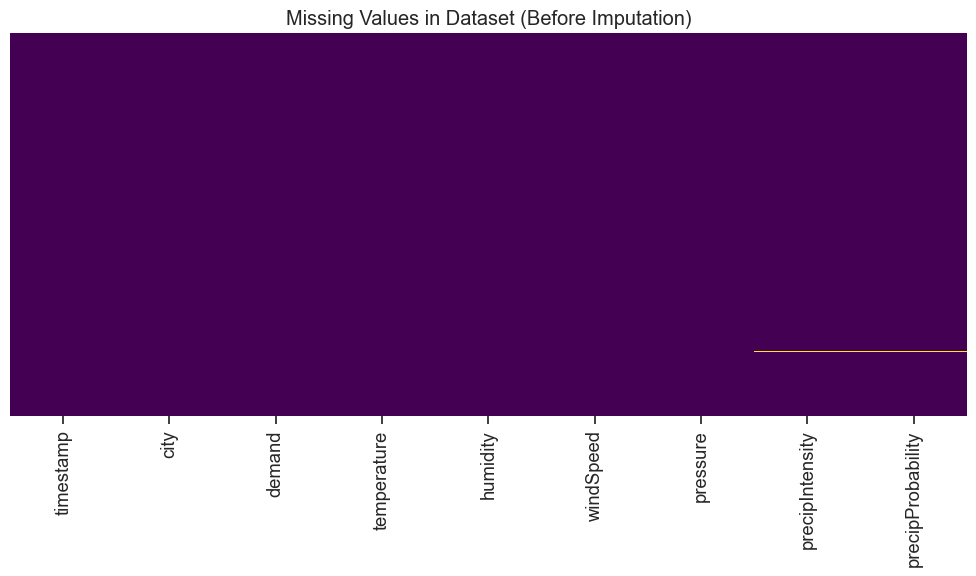

Missing values by column (before imputation):
temperature            9
humidity               9
windSpeed             45
pressure              46
precipIntensity      198
precipProbability    198
dtype: int64

Missing values after imputation:
timestamp            0
city                 0
demand               0
temperature          0
humidity             0
windSpeed            0
pressure             0
precipIntensity      0
precipProbability    0
dtype: int64


In [86]:
# Visualize missing values before imputation
plt.figure(figsize=(10, 6))
sns.heatmap(merged_data.isnull(), cbar=False, yticklabels=False, cmap='viridis')
plt.title('Missing Values in Dataset (Before Imputation)')
plt.tight_layout()
plt.show()

# Count missing values by column
missing_counts = merged_data.isnull().sum()
print("Missing values by column (before imputation):")
print(missing_counts[missing_counts > 0])

# Impute missing values with city-specific medians
for col in ["temperature", "humidity", "windSpeed", "pressure", "precipIntensity", "precipProbability"]:
    merged_data[col] = merged_data.groupby("city")[col].transform(lambda x: x.fillna(x.median()))

# Check missing values after imputation
print("\nMissing values after imputation:")
print(merged_data.isnull().sum())

### Weather Data Distribution

Let's visualize the distribution of weather variables across cities to understand their characteristics and detect potential issues.

## 4. Feature Engineering

We extract time-based features (hour, day of week, month, season) and normalize continuous variables using min-max scaling. These engineered features will help our models capture temporal patterns and seasonal effects in electricity demand.

In [87]:
merged_data['hour'] = merged_data['timestamp'].dt.hour
merged_data['dayofweek'] = merged_data['timestamp'].dt.dayofweek
merged_data['month'] = merged_data['timestamp'].dt.month
merged_data['season'] = merged_data['month'].apply(lambda x: 'winter' if x in [12, 1, 2] else 'spring' if x in [3, 4, 5] else 'summer' if x in [6, 7, 8] else 'autumn')

for col in ["demand", "temperature", "humidity", "windSpeed", "pressure", "precipIntensity", "precipProbability"]:
    min_val = merged_data[col].min()
    max_val = merged_data[col].max()
    merged_data[f"{col}_scaled"] = (merged_data[col] - min_val) / (max_val - min_val)

print(merged_data[["timestamp", "city", "demand", "hour", "dayofweek", "month", "season"]].head())

            timestamp    city    demand  hour  dayofweek  month  season
0 2018-07-02 05:00:00  dallas  13839.70     5          0      7  summer
1 2018-07-02 06:00:00  dallas  14067.03     6          0      7  summer
2 2018-07-02 07:00:00  dallas  14323.09     7          0      7  summer
3 2018-07-02 08:00:00  dallas  14652.59     8          0      7  summer
4 2018-07-02 09:00:00  dallas  15582.09     9          0      7  summer


### Visualizing Aggregated Data

Let's visualize the daily and weekly patterns to better understand the time-based trends in electricity demand across cities.

In [88]:
# First, calculate the daily and weekly aggregations
merged_data['date'] = merged_data['timestamp'].dt.date
merged_data['week'] = merged_data['timestamp'].dt.isocalendar().week

daily_summary = merged_data.groupby(["city", "date"]).agg(avg_demand=("demand", "mean"), max_demand=("demand", "max"), min_demand=("demand", "min"), avg_temp=("temperature", "mean")).reset_index()
weekly_summary = merged_data.groupby(["city", "week"]).agg(avg_demand=("demand", "mean"), avg_temp=("temperature", "mean")).reset_index()

# Convert date column to datetime if needed (for proper display)
daily_summary['date'] = pd.to_datetime(daily_summary['date'])

print("Daily Summary:")
print(daily_summary.head())
print("\nWeekly Summary:")
print(weekly_summary.head())

Daily Summary:
     city       date    avg_demand  max_demand  min_demand   avg_temp
0  dallas 2018-07-02  19853.496316    24432.36    13839.70  89.716316
1  dallas 2018-07-03  18955.707083    24431.58    13628.22  91.135833
2  dallas 2018-07-04  16585.507500    20619.83    12494.99  85.995000
3  dallas 2018-07-05  17137.723750    22809.88    11593.80  84.035833
4  dallas 2018-07-06  16987.939167    21975.81    13094.74  86.249167

Weekly Summary:
     city  week    avg_demand   avg_temp
0  dallas     1  12788.683532  48.238274
1  dallas     2  12418.669603  52.366647
2  dallas     3  12363.146210  52.670536
3  dallas     4  13080.827024  48.068413
4  dallas     5  12597.979841  50.075933


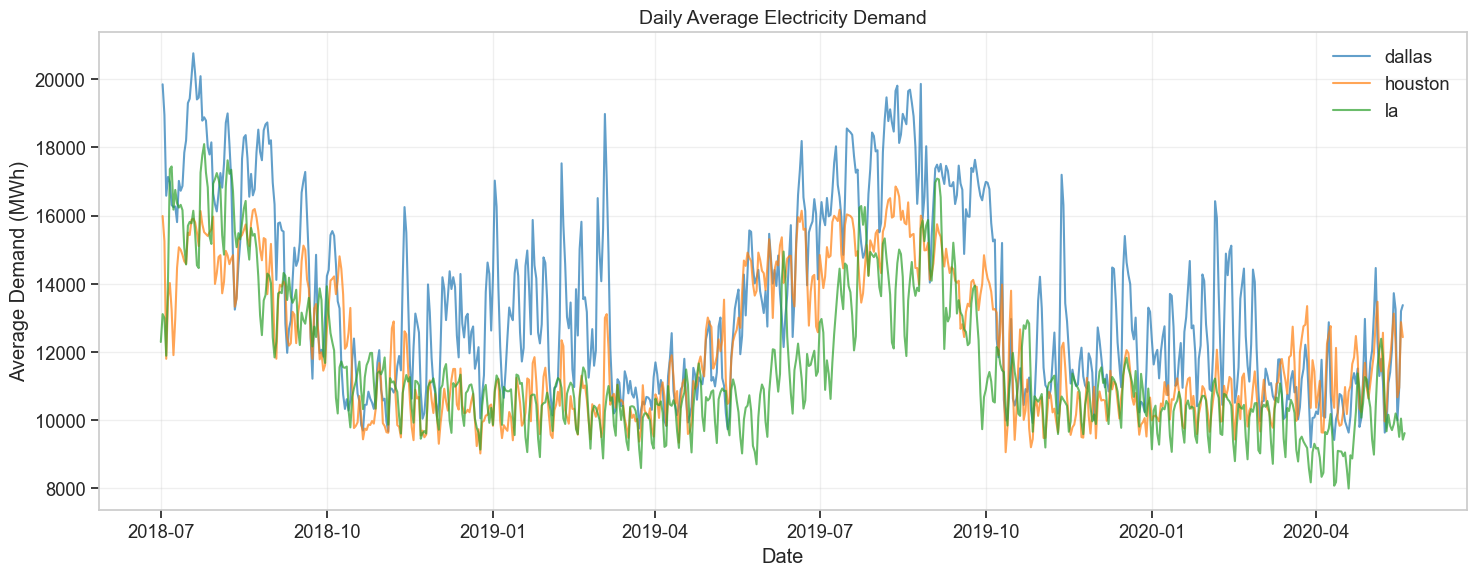

In [89]:
plt.figure(figsize=(15, 6))
for city in daily_summary['city'].unique()[:3]: 
    city_data = daily_summary[daily_summary['city'] == city].sort_values('date')
    plt.plot(city_data['date'], city_data['avg_demand'], label=city, alpha=0.7)

plt.title('Daily Average Electricity Demand', fontsize=14)
plt.xlabel('Date')
plt.ylabel('Average Demand (MWh)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

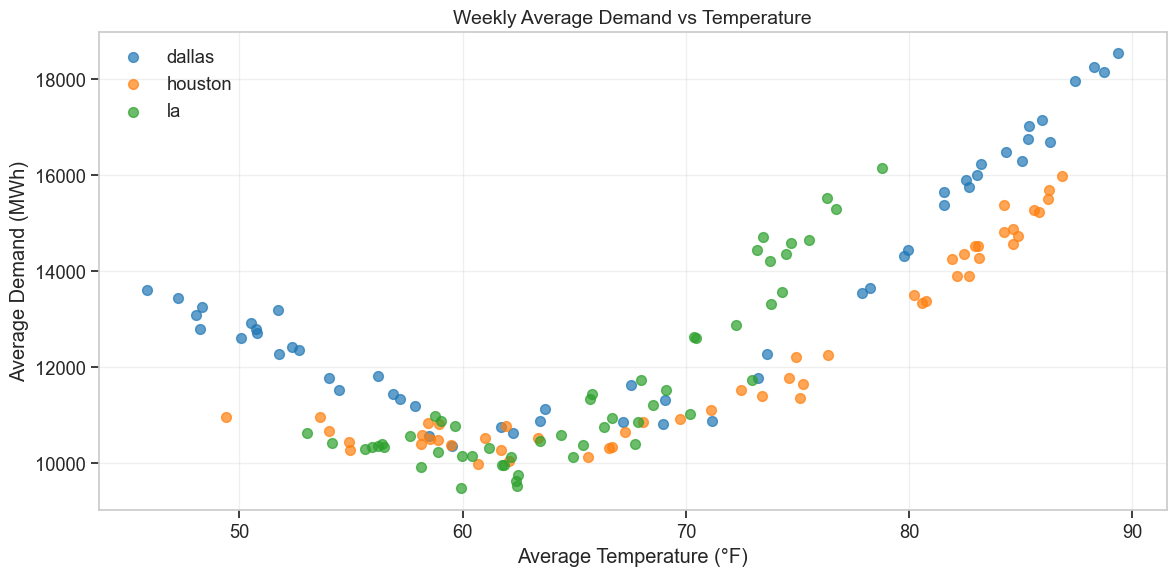

In [90]:
plt.figure(figsize=(12, 6))
for city in weekly_summary['city'].unique()[:3]: 
    city_data = weekly_summary[weekly_summary['city'] == city]
    plt.scatter(city_data['avg_temp'], city_data['avg_demand'], label=city, alpha=0.7, s=50)

plt.title('Weekly Average Demand vs Temperature', fontsize=14)
plt.xlabel('Average Temperature (°F)')
plt.ylabel('Average Demand (MWh)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## 5. Data Aggregation

We now aggregate the data at different time scales to identify patterns and reduce noise. This step is crucial for understanding long-term trends and seasonality in electricity demand.

### Daily and Weekly Aggregation

By summarizing demand and weather features at daily and weekly levels, we can:

- Smooth out hourly fluctuations to reveal underlying patterns
- Reduce the impact of short-term anomalies
- Create features that better capture seasonal and weekly cycles
- Improve visualization and model interpretability
- Enable more efficient storage and processing for long-term analysis

The aggregated data will be used to examine relationships between weather variables and electricity demand at different temporal resolutions.

In [91]:
# We already calculated these aggregations earlier, so let's just use those variables
# The date and week columns are already added to merged_data

# Convert date column to datetime if needed (for proper display)
daily_summary['date'] = pd.to_datetime(daily_summary['date'])

print("Daily Summary:")
print(daily_summary.head())
print("\nWeekly Summary:")
print(weekly_summary.head())

Daily Summary:
     city       date    avg_demand  max_demand  min_demand   avg_temp
0  dallas 2018-07-02  19853.496316    24432.36    13839.70  89.716316
1  dallas 2018-07-03  18955.707083    24431.58    13628.22  91.135833
2  dallas 2018-07-04  16585.507500    20619.83    12494.99  85.995000
3  dallas 2018-07-05  17137.723750    22809.88    11593.80  84.035833
4  dallas 2018-07-06  16987.939167    21975.81    13094.74  86.249167

Weekly Summary:
     city  week    avg_demand   avg_temp
0  dallas     1  12788.683532  48.238274
1  dallas     2  12418.669603  52.366647
2  dallas     3  12363.146210  52.670536
3  dallas     4  13080.827024  48.068413
4  dallas     5  12597.979841  50.075933


## 6. Anomaly Detection Methods

Detecting anomalies in electricity demand and weather data is crucial for accurate forecasting. We implement three complementary methods to identify outliers:

### Z-Score Method
- Identifies values that deviate significantly from the mean
- Points with |z-score| > 3 are flagged as anomalies
- Effective for normally distributed variables
- May be sensitive to extreme values that skew the mean and standard deviation

In [92]:
z_scores = pd.DataFrame()
for feature in ['demand', 'temperature', 'humidity', 'windSpeed', 'pressure']:
    z_scores[feature] = (merged_data[feature] - merged_data[feature].mean()) / merged_data[feature].std()

threshold = 3
outlier_condition = pd.DataFrame()
for feature in ['demand', 'temperature', 'humidity', 'windSpeed', 'pressure']:
    outlier_condition[feature] = abs(z_scores[feature]) > threshold

merged_data['anomaly_z'] = outlier_condition.any(axis=1)

### Interquartile Range (IQR) Method
- Based on robust statistics less affected by extreme values
- Flags points outside Q1 - 1.5×IQR and Q3 + 1.5×IQR
- Works well for skewed distributions
- More resistant to outliers than z-score method

In [93]:
Q1 = merged_data[['demand', 'temperature', 'humidity', 'windSpeed', 'pressure']].quantile(0.25)
Q3 = merged_data[['demand', 'temperature', 'humidity', 'windSpeed', 'pressure']].quantile(0.75)
IQR = Q3 - Q1

merged_data['anomaly_iqr'] = (
    (merged_data['demand'] < (Q1['demand'] - 1.5 * IQR['demand'])) | 
    (merged_data['demand'] > (Q3['demand'] + 1.5 * IQR['demand'])) |
    (merged_data['temperature'] < (Q1['temperature'] - 1.5 * IQR['temperature'])) | 
    (merged_data['temperature'] > (Q3['temperature'] + 1.5 * IQR['temperature'])) |
    (merged_data['humidity'] < (Q1['humidity'] - 1.5 * IQR['humidity'])) | 
    (merged_data['humidity'] > (Q3['humidity'] + 1.5 * IQR['humidity'])) |
    (merged_data['windSpeed'] < (Q1['windSpeed'] - 1.5 * IQR['windSpeed'])) | 
    (merged_data['windSpeed'] > (Q3['windSpeed'] + 1.5 * IQR['windSpeed'])) |
    (merged_data['pressure'] < (Q1['pressure'] - 1.5 * IQR['pressure'])) | 
    (merged_data['pressure'] > (Q3['pressure'] + 1.5 * IQR['pressure'])))

### Isolation Forest 
- Machine learning approach that isolates observations by randomly selecting features
- Anomalies require fewer splits to be isolated
- Performs well with high-dimensional data
- Less affected by data distribution assumptions

In [94]:
X = merged_data[['demand', 'temperature', 'humidity', 'windSpeed', 'pressure']]

iso_forest = IsolationForest(contamination=0.01, random_state=42)
merged_data['anomaly_iso'] = iso_forest.fit_predict(X) == -1  

## Anomaly Detection Visualization and Analysis

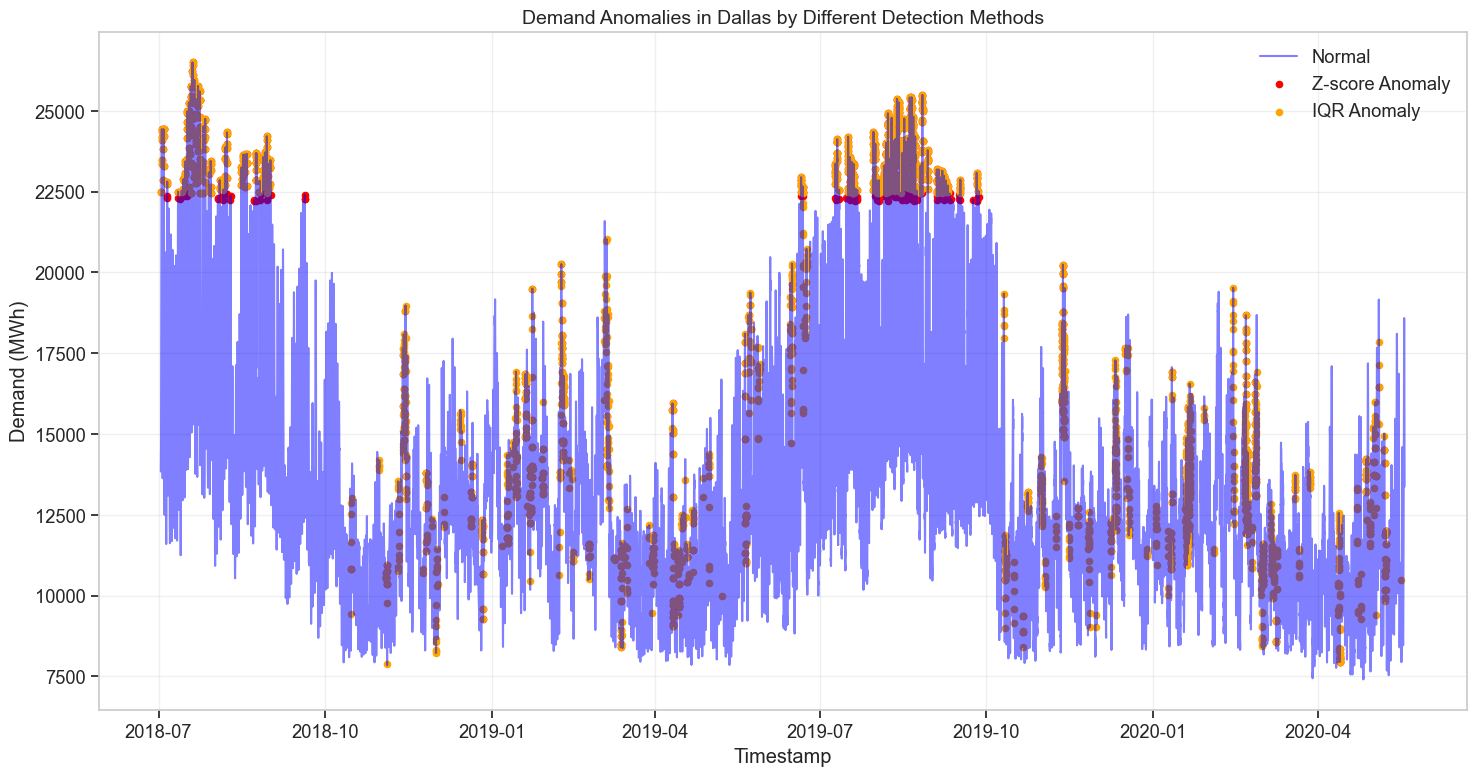

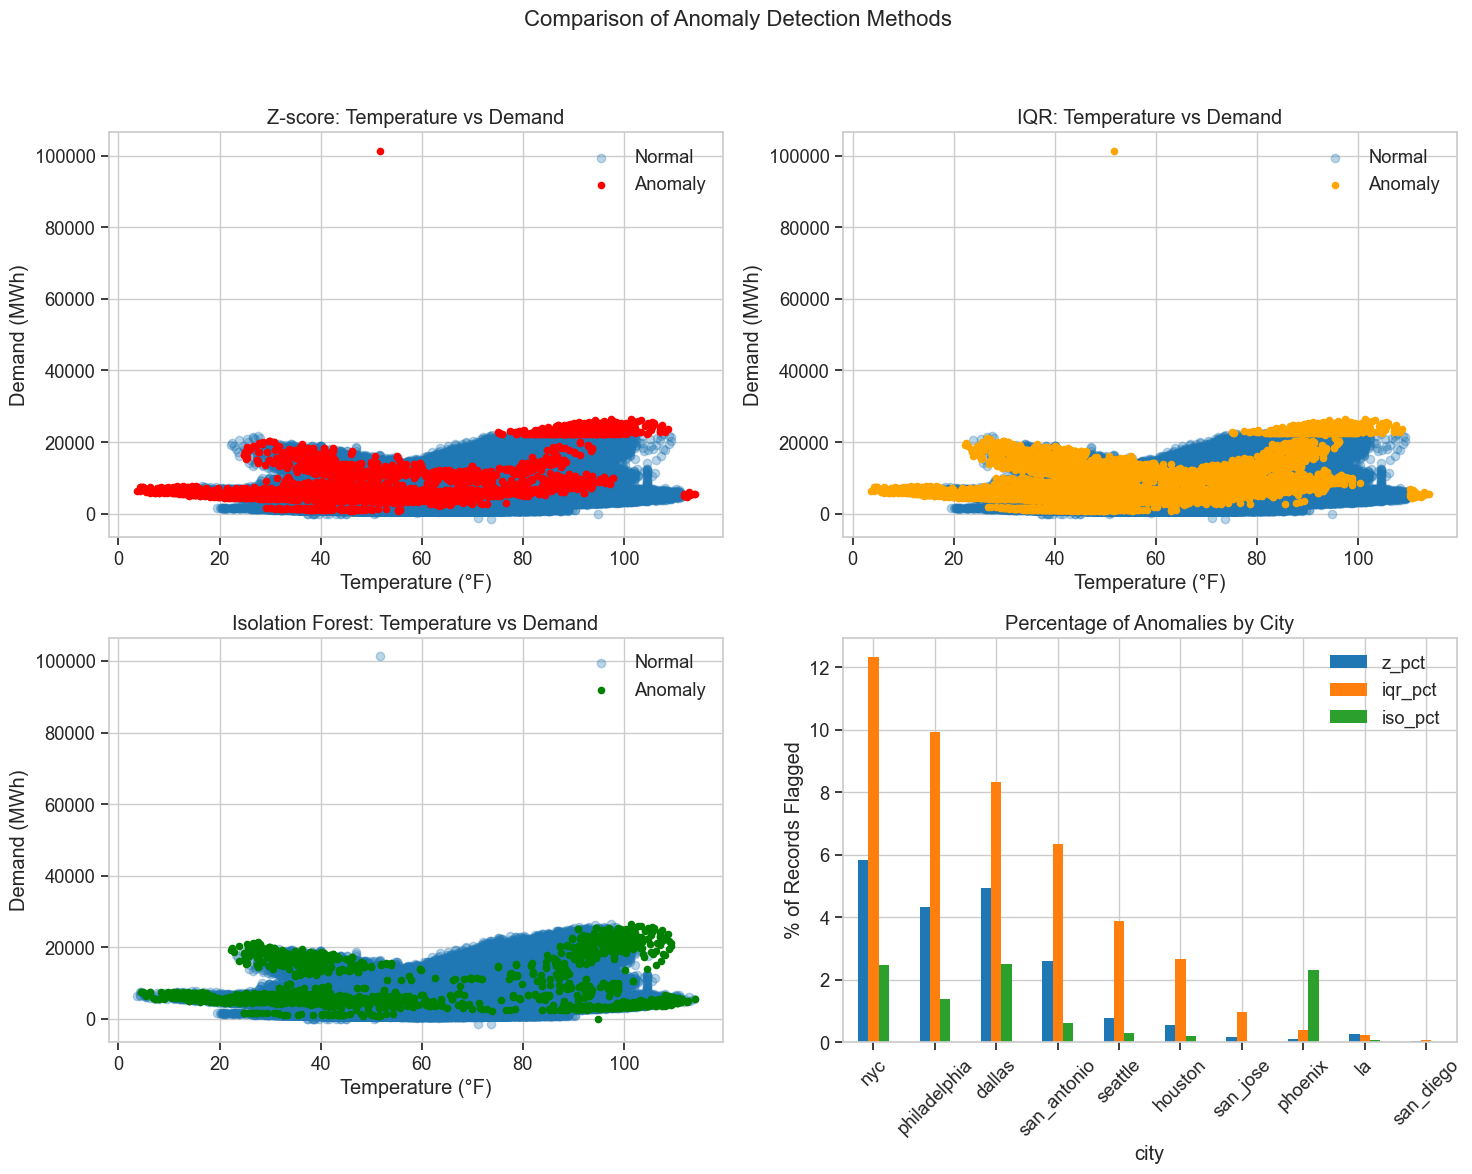

In [95]:
plt.figure(figsize=(15, 8))
sample_city = merged_data['city'].unique()[0]  
city_data = merged_data[merged_data['city'] == sample_city].sort_values('timestamp')

plt.plot(city_data['timestamp'], city_data['demand'], 'b-', alpha=0.5, label='Normal')
plt.scatter(city_data[city_data['anomaly_z']]['timestamp'], 
            city_data[city_data['anomaly_z']]['demand'], 
            color='red', label='Z-score Anomaly', s=20)
plt.scatter(city_data[city_data['anomaly_iqr']]['timestamp'], 
            city_data[city_data['anomaly_iqr']]['demand'], 
            color='orange', label='IQR Anomaly', s=20)
plt.title(f'Demand Anomalies in {sample_city.title()} by Different Detection Methods', fontsize=14)
plt.xlabel('Timestamp')
plt.ylabel('Demand (MWh)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Create a comparison of different anomaly detection methods
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('Comparison of Anomaly Detection Methods', fontsize=16)

axes[0, 0].scatter(merged_data[~merged_data['anomaly_z']]['temperature'], 
                   merged_data[~merged_data['anomaly_z']]['demand'], 
                   alpha=0.3, label='Normal')
axes[0, 0].scatter(merged_data[merged_data['anomaly_z']]['temperature'],
                   merged_data[merged_data['anomaly_z']]['demand'],
                   color='red', label='Anomaly', s=20)
axes[0, 0].set_title('Z-score: Temperature vs Demand')
axes[0, 0].set_xlabel('Temperature (°F)')
axes[0, 0].set_ylabel('Demand (MWh)')
axes[0, 0].legend()

axes[0, 1].scatter(merged_data[~merged_data['anomaly_iqr']]['temperature'],
                   merged_data[~merged_data['anomaly_iqr']]['demand'],
                   alpha=0.3, label='Normal')
axes[0, 1].scatter(merged_data[merged_data['anomaly_iqr']]['temperature'],
                   merged_data[merged_data['anomaly_iqr']]['demand'],
                   color='orange', label='Anomaly', s=20)
axes[0, 1].set_title('IQR: Temperature vs Demand')
axes[0, 1].set_xlabel('Temperature (°F)')
axes[0, 1].set_ylabel('Demand (MWh)')
axes[0, 1].legend()

# 3. Scatter plot of temperature vs demand with Isolation Forest anomalies
axes[1, 0].scatter(merged_data[~merged_data['anomaly_iso']]['temperature'],
                   merged_data[~merged_data['anomaly_iso']]['demand'],
                   alpha=0.3, label='Normal')
axes[1, 0].scatter(merged_data[merged_data['anomaly_iso']]['temperature'],
                   merged_data[merged_data['anomaly_iso']]['demand'],
                   color='green', label='Anomaly', s=20)
axes[1, 0].set_title('Isolation Forest: Temperature vs Demand')
axes[1, 0].set_xlabel('Temperature (°F)')
axes[1, 0].set_ylabel('Demand (MWh)')
axes[1, 0].legend()

anomaly_by_city = merged_data.groupby('city').agg(
    total_records=('demand', 'count'),
    z_anomalies=('anomaly_z', 'sum'),
    iqr_anomalies=('anomaly_iqr', 'sum'),
    iso_anomalies=('anomaly_iso', 'sum')
).reset_index()

anomaly_by_city['z_pct'] = anomaly_by_city['z_anomalies'] / anomaly_by_city['total_records'] * 100
anomaly_by_city['iqr_pct'] = anomaly_by_city['iqr_anomalies'] / anomaly_by_city['total_records'] * 100
anomaly_by_city['iso_pct'] = anomaly_by_city['iso_anomalies'] / anomaly_by_city['total_records'] * 100

anomaly_by_city.sort_values('iqr_pct', ascending=False).plot(
    x='city', y=['z_pct', 'iqr_pct', 'iso_pct'], 
    kind='bar', ax=axes[1, 1]
)
axes[1, 1].set_title('Percentage of Anomalies by City')
axes[1, 1].set_ylabel('% of Records Flagged')
axes[1, 1].set_xticklabels(axes[1, 1].get_xticklabels(), rotation=45)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

### Creating Cleaned Dataset without Anomalies

Based on our analysis, we'll create a cleaned dataset by removing the anomalies detected by the IQR method, which provides a good balance between sensitivity and specificity.

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 [Text(0, 0, 'nyc'),
  Text(1, 0, 'dallas'),
  Text(2, 0, 'philadelphia'),
  Text(3, 0, 'san_antonio'),
  Text(4, 0, 'seattle'),
  Text(5, 0, 'houston'),
  Text(6, 0, 'la'),
  Text(7, 0, 'san_jose'),
  Text(8, 0, 'phoenix'),
  Text(9, 0, 'san_diego')])

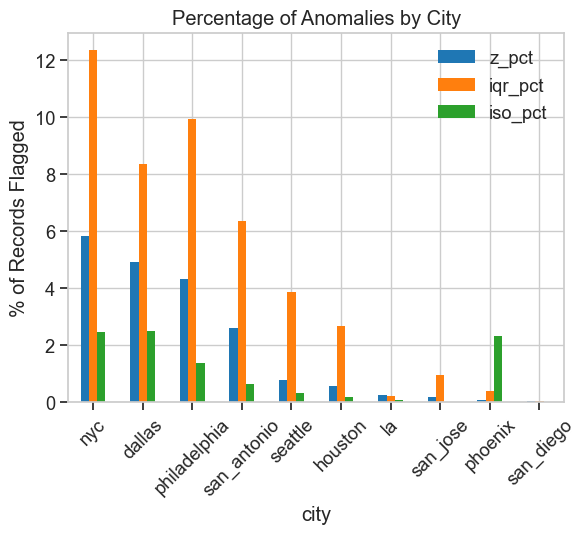

In [96]:
anomaly_by_city = merged_data.groupby('city').agg(
    total_records=('demand', 'count'),
    z_anomalies=('anomaly_z', 'sum'),
    iqr_anomalies=('anomaly_iqr', 'sum'),
    iso_anomalies=('anomaly_iso', 'sum')
).reset_index()

anomaly_by_city['z_pct'] = anomaly_by_city['z_anomalies'] / anomaly_by_city['total_records'] * 100
anomaly_by_city['iqr_pct'] = anomaly_by_city['iqr_anomalies'] / anomaly_by_city['total_records'] * 100
anomaly_by_city['iso_pct'] = anomaly_by_city['iso_anomalies'] / anomaly_by_city['total_records'] * 100

anomaly_by_city.sort_values('z_pct', ascending=False).plot(
    x='city', y=['z_pct', 'iqr_pct', 'iso_pct'], 
    kind='bar', ax=plt.gca()
)
plt.title('Percentage of Anomalies by City')
plt.ylabel('% of Records Flagged')
plt.xticks(rotation=45)

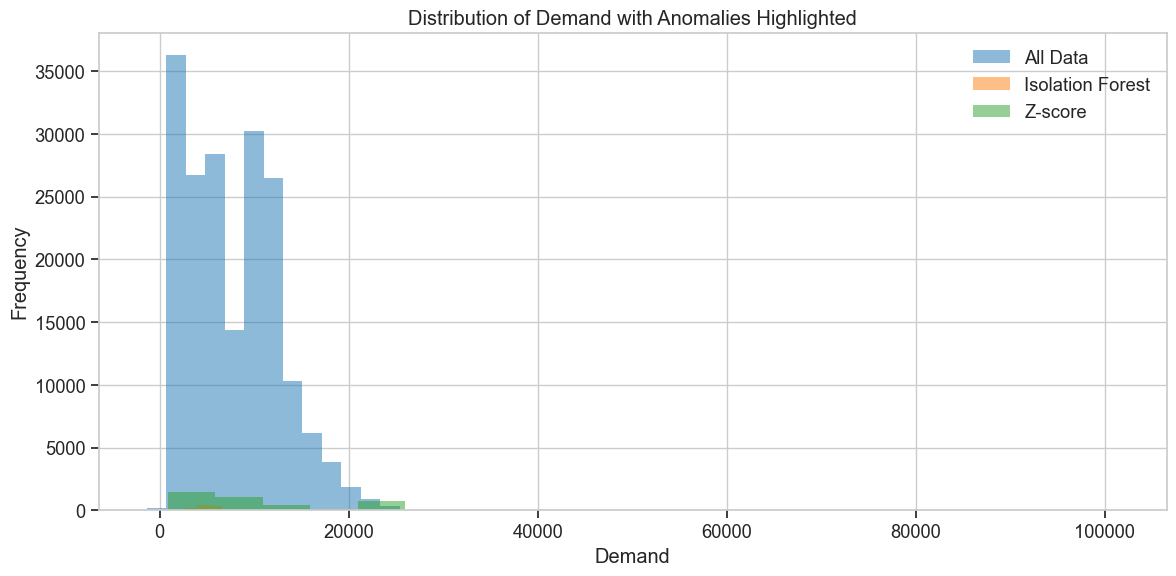

Original dataset shape: (186142, 25)
Cleaned dataset shape: (177485, 25)
Removed 8657 records (4.65% of data)


In [97]:
plt.figure(figsize=(12, 6))
plt.hist(merged_data['demand'], bins=50, alpha=0.5, label='All Data')
plt.hist(merged_data[merged_data['anomaly_iso']]['demand'], bins=20, alpha=0.5, label='Isolation Forest')
plt.hist(merged_data[merged_data['anomaly_z']]['demand'], bins=20, alpha=0.5, label='Z-score')
plt.title('Distribution of Demand with Anomalies Highlighted')
plt.xlabel('Demand')
plt.ylabel('Frequency')
plt.legend()
plt.tight_layout()
plt.show()

# Create cleaned dataset by removing anomalies detected by IQR method
cleaned_data = merged_data[~merged_data['anomaly_iqr']].copy()
print(f"Original dataset shape: {merged_data.shape}")
print(f"Cleaned dataset shape: {cleaned_data.shape}")
print(f"Removed {merged_data.shape[0] - cleaned_data.shape[0]} records ({(merged_data.shape[0] - cleaned_data.shape[0])/merged_data.shape[0]*100:.2f}% of data)")

## 7. Final Data Preparation and Export

Now that we have completed our data preprocessing pipeline, including missing value imputation, feature engineering, aggregation, and anomaly detection, we'll save the processed datasets for further analysis.

In [98]:
os.makedirs(os.path.join(dataset_path, "processed"), exist_ok=True)
merged_data.to_csv(os.path.join(dataset_path, "processed", "load_data.csv"), index=False)
daily_summary.to_csv(os.path.join(dataset_path, "processed", "daily_data.csv"), index=False)
weekly_summary.to_csv(os.path.join(dataset_path, "processed", "weekly_data.csv"), index=False)
cleaned_data.to_csv(os.path.join(dataset_path, "processed", "clean_merged_data.csv"), index=False)

print("Processed datasets saved to:")
for file in ['load_data.csv', 'daily_data.csv', 'weekly_data.csv', 'clean_merged_data.csv']:
    print(f"  - {os.path.join(dataset_path, 'processed', file)}")

Processed datasets saved to:
  - /Users/aaqibnazir/Documents/uni/semester_6/data_mining_project/dataset/processed/load_data.csv
  - /Users/aaqibnazir/Documents/uni/semester_6/data_mining_project/dataset/processed/daily_data.csv
  - /Users/aaqibnazir/Documents/uni/semester_6/data_mining_project/dataset/processed/weekly_data.csv
  - /Users/aaqibnazir/Documents/uni/semester_6/data_mining_project/dataset/processed/clean_merged_data.csv


## Summary

In this notebook, we have completed a comprehensive data preprocessing pipeline for electric load forecasting that includes:

1. **Loading & Merging**: We merged electricity demand data from multiple sources with weather data for 10 major U.S. cities, using canonical city names and timestamps as join keys. This approach ensured city-specific matching and prevented cross-location data mixing.

2. **Missing Value Handling**: We identified and imputed missing values using city-specific median values, which preserves the unique characteristics of each location.

3. **Feature Engineering**: We extracted time-based features (hour, day of week, month, season) and normalized continuous variables to capture temporal patterns and seasonal effects.

4. **Aggregation**: We computed daily and weekly summary statistics to provide insights at different time scales.

5. **Anomaly Detection**: We applied multiple methods (Z-score, IQR, Isolation Forest) to detect outliers and created a cleaned dataset by removing anomalies.

6. **Data Export**: We saved both the full processed dataset and the cleaned version without anomalies, along with daily and weekly aggregations.

The processed datasets are now ready for clustering analysis, time series forecasting, and visualization in the front-end interface. Our preprocessing approach ensures data quality and consistency while preserving important patterns in the data.